In [1]:
import numpy as np
import awkward as ak
import tensorflow as tf
import matplotlib.pyplot as plt

from hepinfo.models.MiVAE import MiVAE
from hepinfo.util import readFromAnomalyBackgroundh5, readFromAnomalySignalh5, awkward_to_numpy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV
from sklearn import linear_model
from sklearn.metrics import roc_auc_score

from functools import partial

from qkeras import quantized_bits
from qkeras.utils import _add_supported_quantized_objects
co = {}; _add_supported_quantized_objects(co)

import h5py
import mplhep
mplhep.style.use('CMS')

In [2]:
# read in the data
normal_data = np.load("../data/normal_data.npy", allow_pickle=True)
abnormal_data = np.load("../data/abnormal_data.npy", allow_pickle=True)

In [3]:
# perform some pre-processing and split into train test
nPV = normal_data[:,0]
nPV_abnormal = abnormal_data[:,0]
X = normal_data[:,1:]
abnormal_data = abnormal_data[:,1:]

X_train, X_test, nPV_train, nPV_test = train_test_split(X, nPV, shuffle=True)
abnormal_data_train, abnormal_data_test, nPV_abnormal_train, nPV_abnormal_test = train_test_split(abnormal_data, nPV_abnormal, shuffle=True)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
abnormal_data_train_scaled = scaler.transform(abnormal_data_train)
abnormal_data_test_scaled = scaler.transform(abnormal_data_test)

In [4]:
def custom_scorer(estimator, X, y, abnormal_data_train_scaled):
    kl_loss = estimator.score_vector(X)[1]
    mean_loss = estimator.get_mean(X).numpy()
    sigma_loss = estimator.get_sigma(X).numpy()

    kl_loss_abnorm = estimator.score_vector(abnormal_data_train_scaled)[1]
    mean_loss_abnorm = estimator.get_mean(abnormal_data_train_scaled).numpy()
    sigma_loss_abnorm = estimator.get_sigma(abnormal_data_train_scaled).numpy()

    X = np.column_stack((kl_loss, mean_loss, sigma_loss))
    X_abnorm = np.column_stack((kl_loss_abnorm, mean_loss_abnorm, sigma_loss_abnorm))
    X_total = np.concatenate((X_abnorm, X))
    X_total = np.nan_to_num(X_total)
    y = np.concatenate((np.ones(len(abnormal_data_train_scaled)), np.zeros(len(X))))

    X_train, X_test, y_train, y_test = train_test_split(X_total, y, shuffle=True, stratify=y)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)

    reg = linear_model.LogisticRegression()
    reg.fit(X_train, y_train)
    auc = roc_auc_score(y_test, reg.predict_proba(X_test)[:,1])

    return auc

scorer = partial(custom_scorer, abnormal_data_train_scaled=abnormal_data_train_scaled)

param_grid = {
    'hidden_layers': [[32, 16], [64, 32]],  # Different network architectures
    'activation': ['relu', 'tanh', 'sigmoid'],  # Different activation functions
    'latent_dims': [4, 8, 16],  # Latent space dimensions
    'drop_out': [0.0, 0.2, 0.4],  # Dropout rates
    'beta_param': [1, 10, 100],  # Weight for KL loss
    'gamma': [1, 10, 100],
    'batch_size': [32, 64, 128, 256],  # Batch sizes
    'learning_rate': [0.001, 0.0001],  # Learning rates
    'optimizer': ['Adam'],  # Different optimizers
    'epoch': [10, 50, 100],  # Number of epochs
    'quantize': [True],
    'num_samples': [10]
}

MiVAE_model = MiVAE(verbose=0, run_eagerly=False, epoch=100, batch_size=256, latent_dims=8, drop_out=0)

grid_search = RandomizedSearchCV(
    MiVAE_model,
    param_grid,
    cv=3,
    n_jobs=1,
    n_iter=10,
    verbose=3,
    scoring=scorer,
    refit=True
)
grid_search.fit(X_train, nPV_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


KeyboardInterrupt: 

In [5]:
# train the model
MiVAE_model = MiVAE(
    verbose=2,
    activation="relu",
    batch_size=256,
    beta_param=1,
    drop_out=0.2,
    epoch=20,
    gamma=1,
    hidden_layers=[64, 32],
    latent_dims=64,
    learning_rate=0.0001,
    optimizer="Adam",
    quantize=True,
    run_eagerly=False
)
history = MiVAE_model.fit(X_train, nPV_train)

MiVAE_model_gamma_zero = MiVAE(
    verbose=2,
    activation="relu",
    batch_size=256,
    beta_param=1,
    drop_out=0.2,
    epoch=20,
    gamma=0,
    hidden_layers=[64, 32],
    latent_dims=64,
    learning_rate=0.0001,
    optimizer="Adam",
    quantize=True,
    run_eagerly=False
)
history_gamma_zero = MiVAE_model_gamma_zero.fit(X_train, nPV_train)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 57)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      3,712 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │      2,080 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 32)        │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 64)        │      2,112 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 64)        │      2,112 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_1          │ (None, 64)        │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bernoulli           │ (None, 64)        │          0 │ sampling_1[0][0]  │
│ (BernoulliSampling) │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,016 (39.12 KB)

 Trainable params: 10,016 (39.12 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 57)             │         3,705 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,897 (30.85 KB)

 Trainable params: 7,897 (30.85 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
586/586 - 4s - 6ms/step - kl_loss: 0.0711 - loss: 0.8323 - mi_loss: 0.1169 - reconstruction_loss: 0.6443
Epoch 2/20
586/586 - 2s - 4ms/step - kl_loss: 0.0017 - loss: 0.6439 - mi_loss: 0.1140 - reconstruction_loss: 0.5281
Epoch 3/20
586/586 - 2s - 4ms/step - kl_loss: 0.0011 - loss: 0.5966 - mi_loss: 0.1145 - reconstruction_loss: 0.4810
Epoch 4/20
586/586 - 2s - 4ms/step - kl_loss: 0.0011 - loss: 0.5805 - mi_loss: 0.1157 - reconstruction_loss: 0.4638
Epoch 5/20
586/586 - 2s - 4ms/step - kl_loss: 0.0010 - loss: 0.5698 - mi_loss: 0.1140 - reconstruction_loss: 0.4549
Epoch 6/20
586/586 - 2s - 4ms/step - kl_loss: 0.0010 - loss: 0.5676 - mi_loss: 0.1156 - reconstruction_loss: 0.4511
Epoch 7/20
586/586 - 2s - 4ms/step - kl_loss: 9.8934e-04 - loss: 0.5623 - mi_loss: 0.1128 - reconstruction_loss: 0.4485
Epoch 8/20
586/586 - 2s - 4ms/step - kl_loss: 9.8714e-04 - loss: 0.5634 - mi_loss: 0.1155 - reconstruction_loss: 0.4469
Epoch 9/20
586/586 - 2s - 4ms/step - kl_loss: 9.7493e-04 - loss:

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 57)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │      3,712 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 64)        │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 32)        │      2,080 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 32)        │          0 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 64)        │      2,112 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 64)        │      2,112 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_2          │ (None, 64)        │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bernoulli           │ (None, 64)        │          0 │ sampling_2[0][0]  │
│ (BernoulliSampling) │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,016 (39.12 KB)

 Trainable params: 10,016 (39.12 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 57)             │         3,705 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,897 (30.85 KB)

 Trainable params: 7,897 (30.85 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
586/586 - 4s - 6ms/step - kl_loss: 0.1566 - loss: 0.7888 - mi_loss: 0.1173 - reconstruction_loss: 0.6321
Epoch 2/20
586/586 - 2s - 4ms/step - kl_loss: 0.0023 - loss: 0.5313 - mi_loss: 0.1159 - reconstruction_loss: 0.5289
Epoch 3/20
586/586 - 2s - 4ms/step - kl_loss: 8.3175e-04 - loss: 0.4838 - mi_loss: 0.1153 - reconstruction_loss: 0.4830
Epoch 4/20
586/586 - 2s - 4ms/step - kl_loss: 3.5221e-04 - loss: 0.4641 - mi_loss: 0.1153 - reconstruction_loss: 0.4637
Epoch 5/20
586/586 - 3s - 4ms/step - kl_loss: 1.6784e-04 - loss: 0.4548 - mi_loss: 0.1142 - reconstruction_loss: 0.4547
Epoch 6/20
586/586 - 2s - 4ms/step - kl_loss: 8.7860e-05 - loss: 0.4498 - mi_loss: 0.1149 - reconstruction_loss: 0.4497
Epoch 7/20
586/586 - 2s - 4ms/step - kl_loss: 5.1416e-05 - loss: 0.4468 - mi_loss: 0.1156 - reconstruction_loss: 0.4467
Epoch 8/20
586/586 - 2s - 4ms/step - kl_loss: 3.4121e-05 - loss: 0.4446 - mi_loss: 0.1154 - reconstruction_loss: 0.4446
Epoch 9/20
586/586 - 2s - 4ms/step - kl_loss: 2.

In [15]:
# plot scripts

def plot_history(history):
    plt.plot(history.history['loss'], label='Train Total Loss')
    plt.plot(history.history['reconstruction_loss'], label='Train Reconstruction Loss')
    plt.plot(history.history['kl_loss'], label='Train KL Loss')
    plt.plot(history.history['mi_loss'], label='Train MI Loss')
    plt.yscale("log")
    plt.ylabel("Total loss")
    plt.xlabel("Epoch")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

def plot_score(normal_score, abnormal_score, bin_size=100, xlabel="Reconstruction Loss", ylabel="Probability (a.u.)"):
    # get range for peak
    combined = np.concatenate([normal_score, abnormal_score])
    lower_bound = np.percentile(combined, 1)
    upper_bound = np.percentile(combined, 99)

    plt.hist(normal_score, bins=bin_size, label="dijet+ttbar", density=True, histtype='step', fill=False, linewidth=1.5, range=(lower_bound, upper_bound))
    plt.hist(abnormal_score, bins=bin_size, label="higgs", density=True, histtype='step', fill=False, linewidth=1.5, range=(lower_bound, upper_bound))
    plt.yscale('log')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='best')
    plt.show()

def plot_roc(y_test, y_pred, name="Reconstruction"):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc_value = auc(fpr, tpr)

    # find the index of the maximum Youden's J
    youden_j = tpr - fpr
    best_index = np.argmax(youden_j)
    best_threshold = thresholds[best_index]

    plt.scatter(fpr[best_index], tpr[best_index])
    plt.plot(fpr, tpr, "-", label=f"{name} (auc = {round(auc_value, 3)})", linewidth=1.5)
    return best_threshold

def get_plots(model, normal_data, abnormal_data, nPV_normal, nPV_abnormal, name=r"$\gamma=0$"):
    # get the different score types
    recon_normal_score = np.nan_to_num(model.score_vector(normal_data)[0])
    recon_abnormal_score = np.nan_to_num(model.score_vector(abnormal_data)[0])

    kl_normal_score = np.nan_to_num(model.score_vector(normal_data)[1])
    kl_abnormal_score = np.nan_to_num(model.score_vector(abnormal_data)[1])

    total_normal_score = np.nan_to_num(model.score_vector(normal_data)[2])
    total_abnormal_score = np.nan_to_num(model.score_vector(abnormal_data)[2])

    mean_normal_score = model.get_mean(normal_data).numpy()
    mean_normal_score = np.sum(mean_normal_score**2, axis=1)
    mean_abnormal_score = model.get_mean(abnormal_data).numpy()
    mean_abnormal_score = np.sum(mean_abnormal_score**2, axis=1)

    sigma_normal_score = model.get_sigma(normal_data).numpy()
    sigma_normal_score = np.sum(sigma_normal_score**2, axis=1)
    sigma_abnormal_score = model.get_sigma(abnormal_data).numpy()
    sigma_abnormal_score = np.sum(sigma_abnormal_score**2, axis=1)

    plot_score(recon_normal_score, recon_abnormal_score, xlabel="Reconstruction score " + name, ylabel="Probability (a.u.)")
    plot_score(kl_normal_score, kl_abnormal_score, xlabel="KL score " + name, ylabel="Probability (a.u.)")
    plot_score(total_normal_score, total_abnormal_score, xlabel="Total score " + name, ylabel="Probability (a.u.)")
    plot_score(mean_normal_score, mean_abnormal_score, xlabel=r"$\sum \mu^2$ score " + name, ylabel="Probability (a.u.)")
    plot_score(sigma_normal_score, sigma_abnormal_score, xlabel=r"$\sum \sigma^2$ score " + name, ylabel="Probability (a.u.)")

    # generate plots for the ROC curves
    y_test = np.concatenate((np.ones(len(recon_abnormal_score)), np.zeros(len(recon_normal_score))))
    thr_recon = plot_roc(y_test, np.concatenate((recon_abnormal_score, recon_normal_score)), name="Reconstruction score " + name)
    thr_kl = plot_roc(y_test, np.concatenate((kl_abnormal_score, kl_normal_score)), name="KL score " + name)
    thr_total = plot_roc(y_test, np.concatenate((total_abnormal_score, total_normal_score)), name="Total score " + name)
    thr_mean = plot_roc(y_test, np.concatenate((mean_abnormal_score, mean_normal_score)), name=r"$\sum \mu^2$ score " + name)
    thr_sigma = plot_roc(y_test, np.concatenate((sigma_abnormal_score, sigma_normal_score)), name=r"$\sum \sigma^2$ score " + name)

    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
    plt.show()

    # generate plots for pile-up studies
    bins = 20

    if not nPV_normal is None: plt.hist(nPV_normal, bins=bins, density=True, alpha=0.3, label="dijet+ttbar no cut " + name)
    if not nPV_abnormal is None: plt.hist(nPV_abnormal, bins=bins, density=True, alpha=0.3, label="higgs no cut " + name)

    if not nPV_normal is None: plt.hist(nPV_normal[recon_normal_score > thr_recon], bins=bins, density=True, alpha=0.3, label="dijet+ttbar recon cut")
    if not nPV_abnormal is None: plt.hist(nPV_abnormal[recon_abnormal_score > thr_recon], bins=bins, density=True, alpha=0.3, label="higgs cut recon cut")

    if not nPV_normal is None: plt.hist(nPV_normal[kl_normal_score > thr_kl], bins=bins, density=True, alpha=0.3, label="dijet+ttbar KL cut")
    if not nPV_abnormal is None: plt.hist(nPV_abnormal[kl_abnormal_score > thr_kl], bins=bins, density=True, alpha=0.3, label="higgs cut KL cut")

    if not nPV_normal is None: plt.hist(nPV_normal[total_normal_score > thr_total], bins=bins, density=True, alpha=0.3, label="dijet+ttbar total cut")
    if not nPV_abnormal is None: plt.hist(nPV_abnormal[total_abnormal_score > thr_total], bins=bins, density=True, alpha=0.3, label="higgs cut total cut")

    if not nPV_normal is None: plt.hist(nPV_normal[mean_normal_score > thr_mean], bins=bins, density=True, alpha=0.3, label="dijet+ttbar mean cut " + name)
    if not nPV_abnormal is None: plt.hist(nPV_abnormal[mean_abnormal_score > thr_mean], bins=bins, density=True, alpha=0.3, label="higgs cut mean cut " + name)

    if not nPV_normal is None: plt.hist(nPV_normal[sigma_normal_score > thr_sigma], bins=bins, density=True, alpha=0.3, label="dijet+ttbar sigma cut " + name)
    if not nPV_abnormal is None: plt.hist(nPV_abnormal[sigma_abnormal_score > thr_sigma], bins=bins, density=True, alpha=0.3, label="higgs cut sigma cut " + name)

    if nPV_normal is not None or nPV_abnormal is not None:
        plt.xlabel("nPV")
        plt.ylabel("Events (%)")

        plt.legend(loc='best', ncol=2, prop={'size': 8})
        plt.grid(True)

        plt.show()


In [ ]:
plot_history(history)
get_plots(MiVAE_model, X_test, abnormal_data_test_scaled, nPV_test, nPV_abnormal_test, name=r"$\gamma=1$")
get_plots(MiVAE_model_gamma_zero, X_test, abnormal_data_test_scaled, nPV_test, nPV_abnormal_test, name=r"$\gamma=0$")

### Analyse real data

In [2]:
# load model and scaling parameters
model = tf.keras.models.load_model('../data/encoder_trimmed.h5', custom_objects=co)

input_quantizer = quantized_bits(8,5,alpha=1)
scales = h5py.File('../data/scales.h5')
scale_data = scales['norm_scale'][:].flatten()
offset_data = scales['norm_bias'][:].flatten()

In [3]:
# prepare background data for inference
NEG=4
NMU=4
NJET=10

# read in normal data
X = readFromAnomalyBackgroundh5('../data/run370293.h5', object_ranges='default2')

X_flat = np.zeros((X[0]['nEvents'], 57), dtype='int')
X_flat[:,0] = ak.flatten(X[2].sums[:].pt)
X_flat[:,2] = ak.flatten(X[2].sums[:].phi)
X_flat[:,3:3+3*(NEG)] = awkward_to_numpy(X[2].egs, NEG)
X_flat[:,3+3*(NEG):3+3*(NMU+NEG)] = awkward_to_numpy(X[2].muons, NMU)
X_flat[:,3+3*(NMU+NEG):3+3*(NMU+NEG+NJET)] = awkward_to_numpy(X[2].jets, NJET)

# scale data and get pile-up
nPV = ak.to_numpy(X[1]['nPV'])
nPV_Good = ak.to_numpy(X[1]['nPV_Good'])
X_scaled = input_quantizer((X_flat.astype('float') - offset_data) / scale_data)
batch_size = len(X_scaled)

# read in abnormal data
cms_HHHTo6B = readFromAnomalySignalh5('../data/BSM_preprocessed.h5', 'HHHTo6B', object_ranges='default2')

cms_HHHTo6B_flat = np.zeros((cms_HHHTo6B[0]['nEvents'], 57), dtype='int')
cms_HHHTo6B_flat[:,0] = ak.flatten(cms_HHHTo6B[2].sums[:].pt)
cms_HHHTo6B_flat[:,2] = ak.flatten(cms_HHHTo6B[2].sums[:].phi)
cms_HHHTo6B_flat[:,3:3+3*(NEG)] = awkward_to_numpy(cms_HHHTo6B[2].egs, NEG)
cms_HHHTo6B_flat[:,3+3*(NEG):3+3*(NMU+NEG)] = awkward_to_numpy(cms_HHHTo6B[2].muons, NMU)
cms_HHHTo6B_flat[:,3+3*(NMU+NEG):3+3*(NMU+NEG+NJET)] = awkward_to_numpy(cms_HHHTo6B[2].jets, NJET)

# scale abnormal data
cms_HHHTo6B_scaled = input_quantizer((cms_HHHTo6B_flat.astype('float') - offset_data) / scale_data)

In [9]:
# split data for training / testing
partial_data = 100000
X_train, X_test, nPV_train, nPV_test = train_test_split(X_scaled.numpy()[:partial_data], nPV[:partial_data], random_state=42)

In [5]:
# train the model
MiVAE_cms_model = MiVAE(
    verbose=2,
    activation="relu",
    batch_size=256,
    beta_param=1,
    drop_out=0.2,
    epoch=20,
    gamma=1,
    hidden_layers=[32, 16, 13],
    latent_dims=64,
    learning_rate=0.0001,
    optimizer="Adam",
    quantize=True,
    run_eagerly=False
)
history = MiVAE_cms_model.fit(X_train, nPV_train)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 57)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      1,856 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │        528 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 13)        │        221 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 13)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 64)        │        896 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 64)        │        896 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 64)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bernoulli           │ (None, 64)        │          0 │ sampling[0][0]    │
│ (BernoulliSampling) │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,397 (17.18 KB)

 Trainable params: 4,397 (17.18 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 13)             │           845 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 57)             │         1,881 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,494 (13.65 KB)

 Trainable params: 3,494 (13.65 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
293/293 - 3s - 11ms/step - kl_loss: 145.8474 - loss: 151.9190 - mi_loss: 0.7278 - reconstruction_loss: 5.3436
Epoch 2/20
293/293 - 2s - 5ms/step - kl_loss: 39.1251 - loss: 45.0352 - mi_loss: 0.6395 - reconstruction_loss: 5.2705
Epoch 3/20
293/293 - 1s - 4ms/step - kl_loss: 24.7219 - loss: 30.4934 - mi_loss: 0.5776 - reconstruction_loss: 5.1939
Epoch 4/20
293/293 - 1s - 5ms/step - kl_loss: 18.0394 - loss: 23.6992 - mi_loss: 0.5266 - reconstruction_loss: 5.1332
Epoch 5/20
293/293 - 1s - 5ms/step - kl_loss: 14.1931 - loss: 19.7666 - mi_loss: 0.4898 - reconstruction_loss: 5.0836
Epoch 6/20
293/293 - 1s - 5ms/step - kl_loss: 11.7031 - loss: 17.2140 - mi_loss: 0.4567 - reconstruction_loss: 5.0542
Epoch 7/20
293/293 - 2s - 6ms/step - kl_loss: 9.9330 - loss: 15.3969 - mi_loss: 0.4338 - reconstruction_loss: 5.0301
Epoch 8/20
293/293 - 1s - 5ms/step - kl_loss: 8.6009 - loss: 14.0286 - mi_loss: 0.4074 - reconstruction_loss: 5.0203
Epoch 9/20
293/293 - 1s - 5ms/step - kl_loss: 7.5532 - 

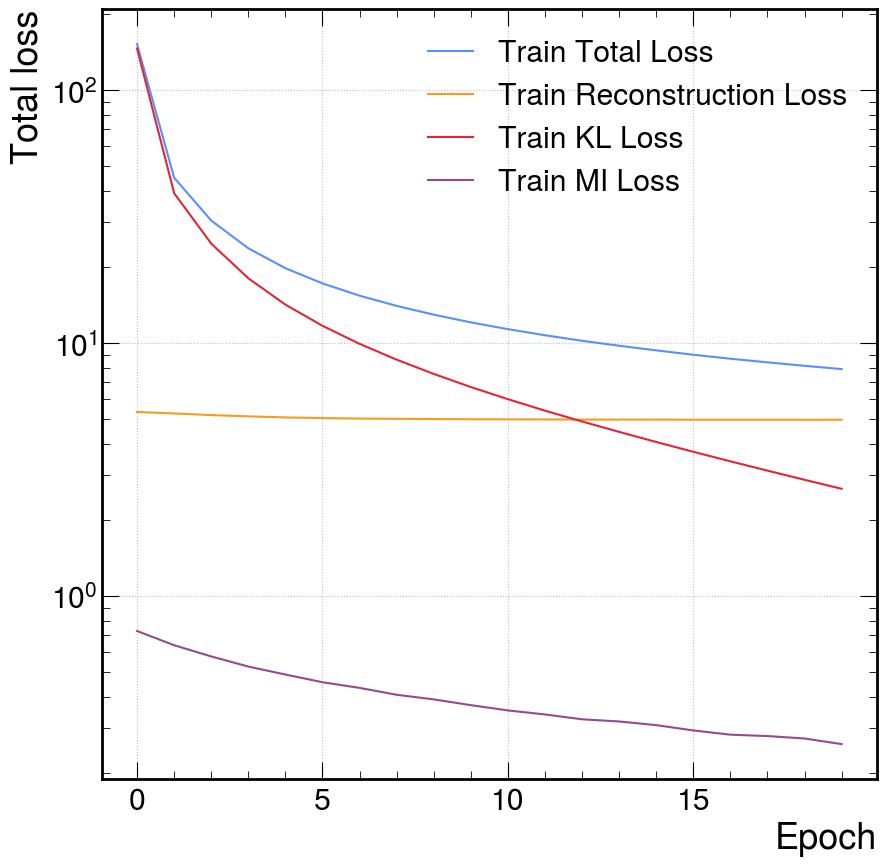

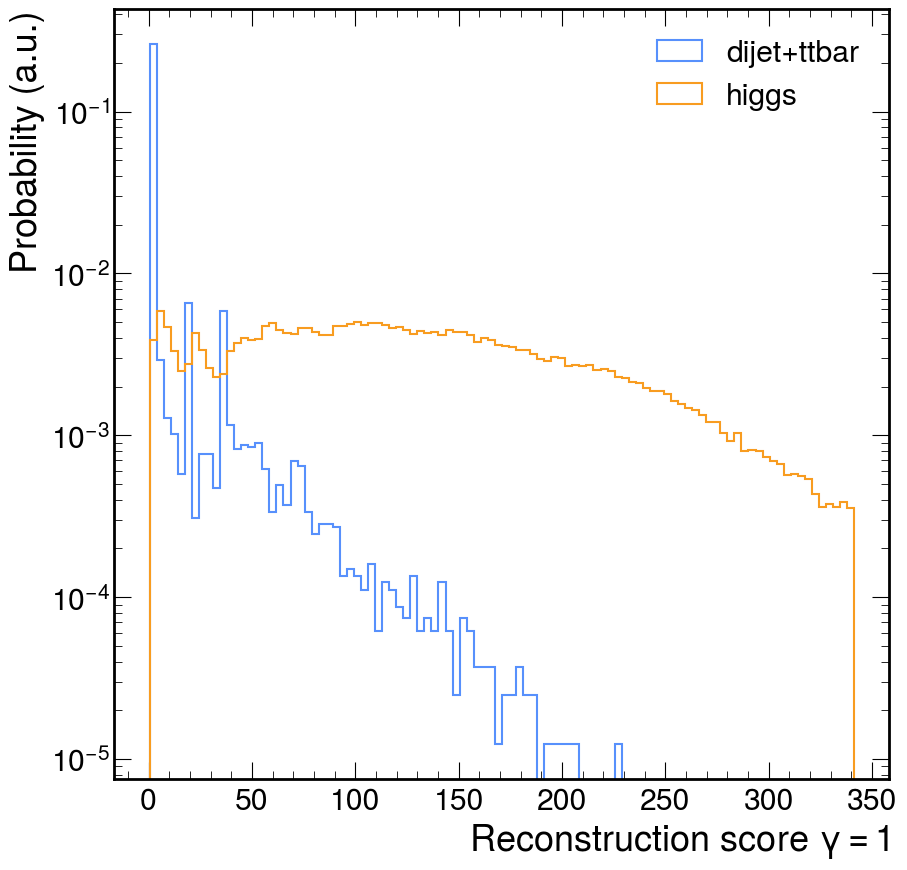

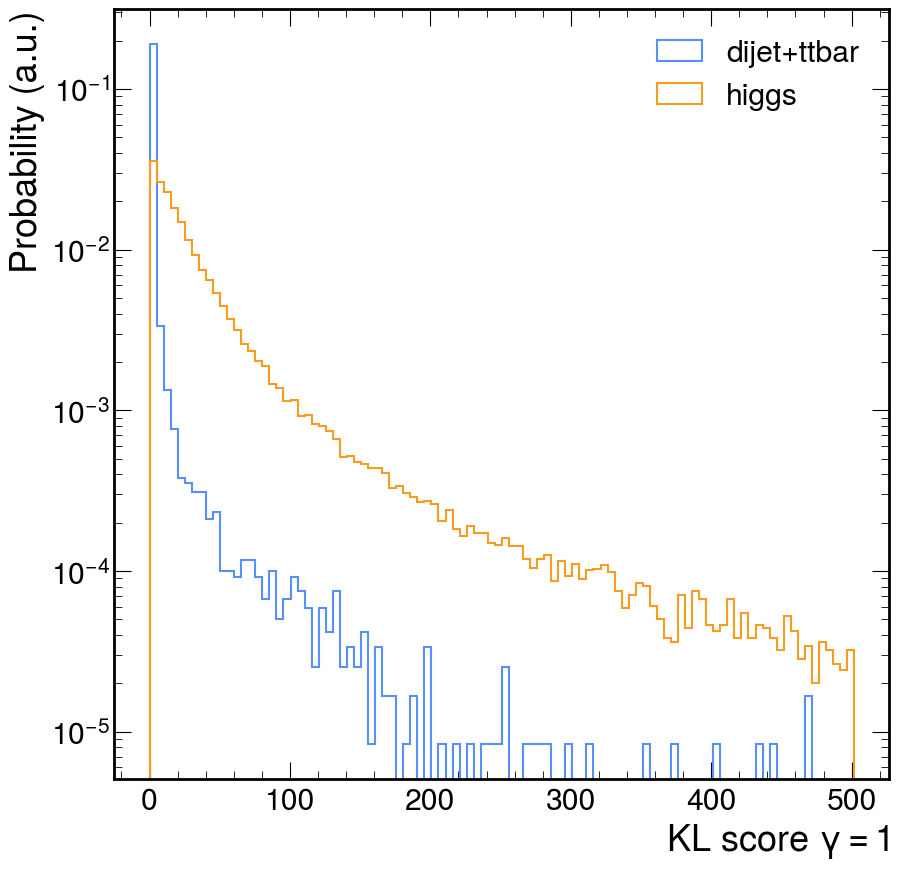

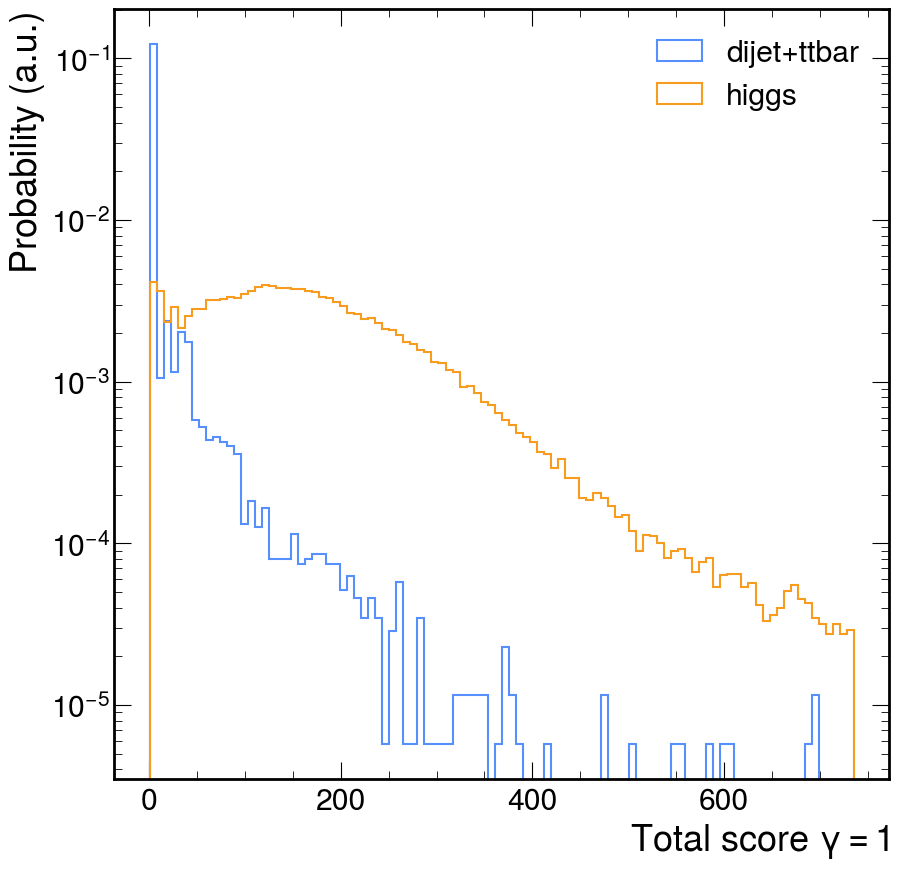

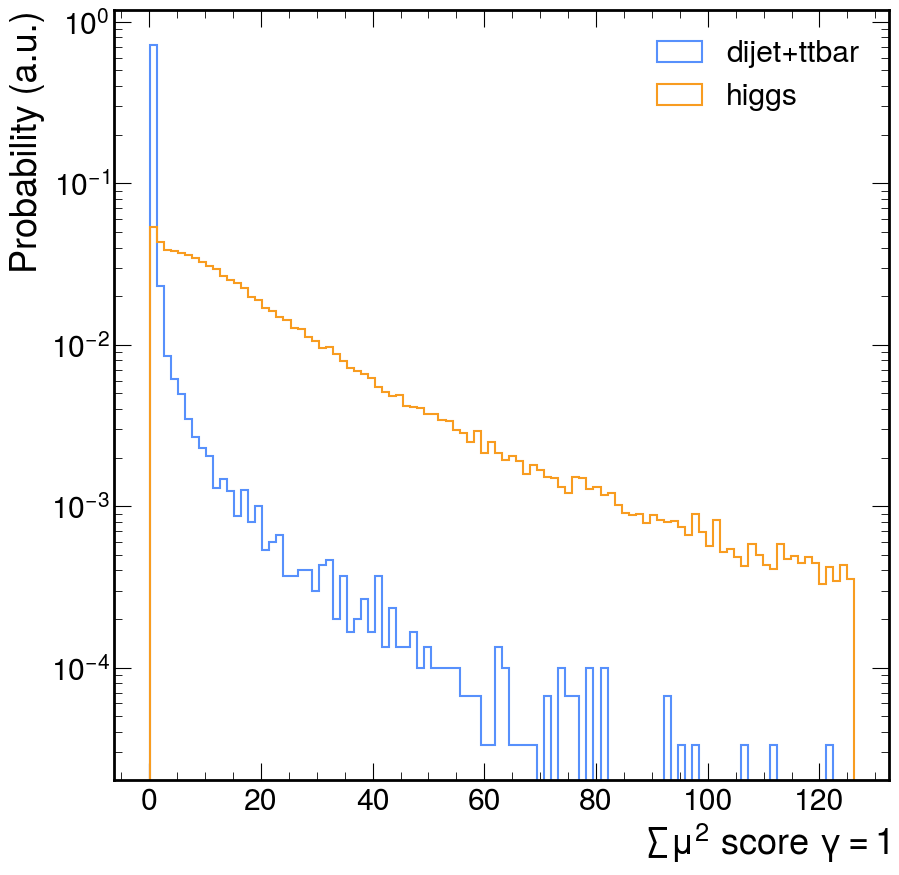

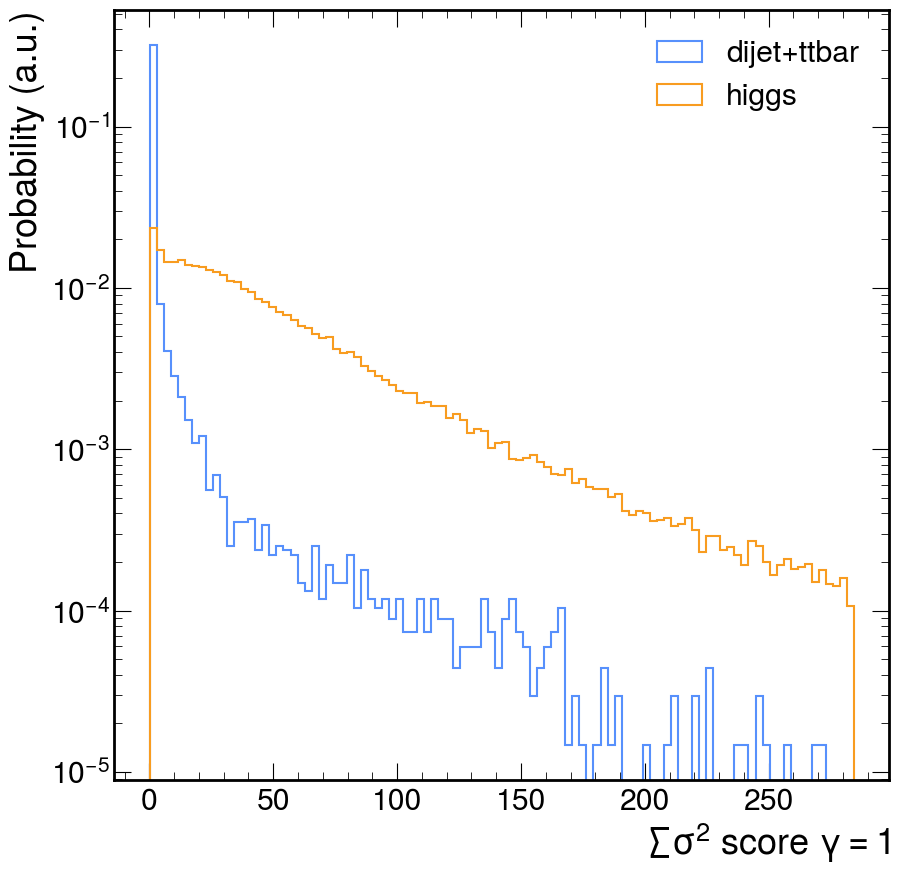

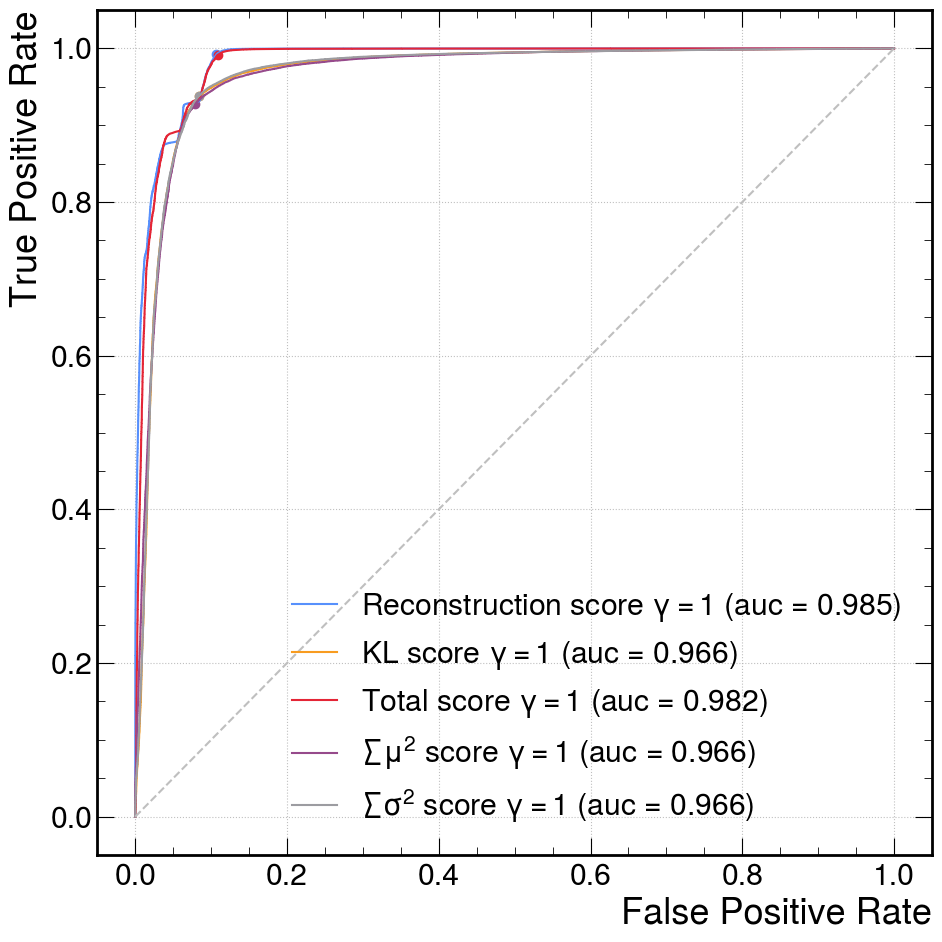

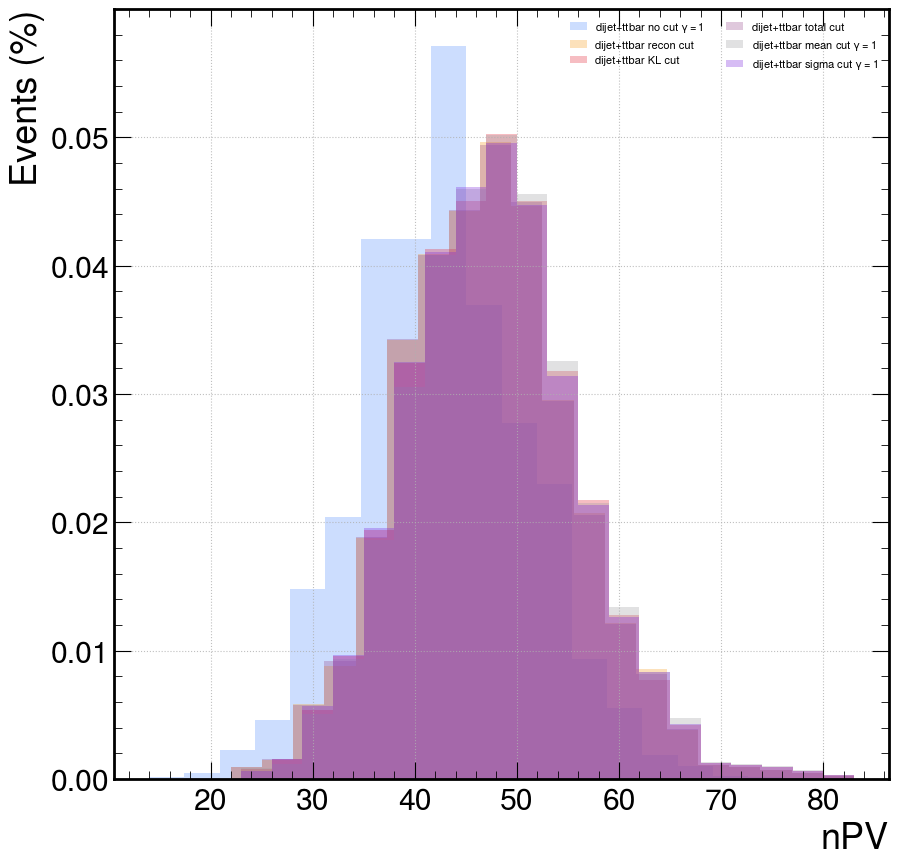

In [16]:
plot_history(history)
get_plots(MiVAE_cms_model, X_test, cms_HHHTo6B_scaled[:partial_data], nPV_test, None, name=r"$\gamma=1$")

In [ ]:
latent_axo_normal = model.predict(X_test, batch_size=batch_size)
latent_axo_abnormal = model.predict(cms_HHHTo6B_scaled[:partial_data], batch_size=batch_size)

    recon_normal_score = np.nan_to_num(model.score_vector(normal_data)[0])
    recon_abnormal_score = np.nan_to_num(model.score_vector(abnormal_data)[0])

    kl_normal_score = np.nan_to_num(model.score_vector(normal_data)[1])
    kl_abnormal_score = np.nan_to_num(model.score_vector(abnormal_data)[1])

    total_normal_score = np.nan_to_num(model.score_vector(normal_data)[2])
    total_abnormal_score = np.nan_to_num(model.score_vector(abnormal_data)[2])
